In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [3]:
PATH = "data/plant-seedlings/"

In [4]:
sz = 256
arch = resnet50
bs = 64
# try 224, 58 and 299, 58

In [5]:
label_csv = f'{PATH}labels.csv'
n = len(list(open(label_csv))) - 1
val_idxs = get_cv_idxs(n)

In [6]:
label_df = pd.read_csv(label_csv)

## Removing space between class names

In [ ]:
label_df.species = label_df.species.apply(lambda x: re.sub(' ', '_', x))
label_df.to_csv(f'{PATH}labels.csv', index=False)

## Pivot table

In [ ]:
label_df.pivot_table(index='species', aggfunc=len).sort_values('file', ascending=False)

## Analysis

In [ ]:
row_sz = [PIL.Image.open(f'{PATH}train/'+k).size[0] for k in os.listdir(f'{PATH}train/')]

In [ ]:
col_sz = [PIL.Image.open(f'{PATH}train/'+k).size[1] for k in os.listdir(f'{PATH}train/')]

In [ ]:
row_sz = np.array(row_sz); col_sz = np.array(col_sz)

In [ ]:
plt.hist(row_sz[row_sz < 500]);

In [ ]:
plt.hist(col_sz[col_sz < 500]);

## Training setup

In [7]:
def get_data(sz, bs):
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
    data = ImageClassifierData.from_csv(PATH, 'train', f'{PATH}labels.csv', test_name='test',
                                        val_idxs=val_idxs, tfms=tfms, bs=bs)
    return data if sz>300 else data.resize(340, 'tmp')

In [8]:
data = get_data(sz, bs)

HBox(children=(IntProgress(value=0, max=6), HTML(value='')))

In [9]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

100%|██████████| 13/13 [00:33<00:00,  2.60s/it]


HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 95%|█████████▌| 57/60 [00:06<00:00,  9.35it/s, loss=15.4]


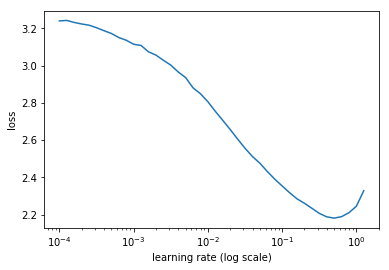

In [10]:
lrf=learn.lr_find()
learn.sched.plot()

In [11]:
lr = 1e-2

In [12]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

[ 0.       1.3256   0.81298  0.75316]                     
[ 1.       0.87833  0.5404   0.82893]                      
[ 2.       0.64175  0.48303  0.85243]                      
[ 3.       0.53251  0.45228  0.84722]                      
[ 4.       0.43918  0.39621  0.8691 ]                      
[ 5.       0.35285  0.3795   0.87052]                      
[ 6.       0.31661  0.37538  0.87157]                      



In [18]:
from sklearn import metrics

In [19]:
learn.ps = 0.5

In [21]:
sz = 400

In [22]:
data = get_data(sz, 32)

In [23]:
learn.set_data(data)

In [24]:
learn.freeze()
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

[ 0.       0.32125  0.3774   0.87176]                      
[ 1.       0.3098   0.38229  0.86948]                      
[ 2.       0.27345  0.36113  0.86948]                      
[ 3.       0.26674  0.35981  0.87307]                      
[ 4.       0.23855  0.34897  0.88009]                      
[ 5.       0.20729  0.34086  0.89259]                      
[ 6.       0.18429  0.33839  0.88738]                      



In [25]:
lrs = np.array([lr/9,lr/3,lr])

In [26]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)
learn.save(f'{sz}')

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

[ 0.       0.55815  0.34303  0.88864]                        
[ 1.       0.50853  0.3469   0.87926]                        
[ 2.       0.41679  0.29353  0.90009]                        
[ 3.       0.4235   0.32311  0.88239]                        
[ 4.       0.3848   0.29019  0.90009]                        
[ 5.       0.33209  0.24542  0.91941]                        
[ 6.       0.3107   0.24728  0.92301]                        



In [27]:
sz = 450

In [28]:
learn.set_data(get_data(sz, 24))

In [29]:
learn.freeze()
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

[ 0.       0.41807  0.27848  0.90164]                        
[ 1.       0.4372   0.25541  0.92009]                        
[ 2.       0.32842  0.24508  0.92143]                        
[ 3.       0.39954  0.29756  0.9128 ]                        
[ 4.       0.34512  0.23752  0.92664]                        
[ 5.       0.28683  0.23047  0.93051]                        
[ 6.       0.24392  0.23175  0.92559]                        



In [30]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)
learn.save(f'{sz}')

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

[ 0.       0.48141  0.27604  0.90238]                        
[ 1.       0.32358  0.29003  0.89792]                        
[ 2.       0.18421  0.16032  0.94063]                        
[ 3.       0.23668  0.21731  0.92946]                        
[ 4.       0.16108  0.13418  0.95104]                        
[ 5.       0.08198  0.13152  0.95417]                         
[ 6.       0.0708   0.12687  0.95937]                         



In [31]:
learn.precompute=False
learn.bn_freeze=True

In [33]:
learn.fit(lr, 1, cycle_len=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

[ 0.       0.42319  0.34327  0.88333]                        
[ 1.       0.18277  0.19761  0.94063]                        



In [34]:
learn.save(f'{sz}')

In [35]:
learn.load(f'{sz}')

## Old steps

In [ ]:
learn.set_data(get_data(299, bs))
learn.freeze()

In [ ]:
learn.fit(1e-2, 3, cycle_len=1)

In [ ]:
learn.fit(1e-2, 3, cycle_len=1, cycle_mult=2)

In [ ]:
learn.save('299_r50')

In [ ]:
learn.load('299_r50')

In [ ]:
learn.set_data(get_data(350, bs))
learn.freeze()

In [ ]:
learn.fit(1e-2, 3, cycle_len=1)

In [ ]:
learn.fit(1e-2, 3, cycle_len=1, cycle_mult=2)

In [ ]:
learn.save('350_r50')

In [ ]:
learn.load('350_r50')

In [ ]:
log_preds, y = learn.TTA()
probs = np.exp(log_preds)

In [ ]:
accuracy(log_preds, y)

In [ ]:
metrics.f1_score()

In [ ]:
learn.save('350_r50')

## Prediction

In [36]:
log_preds, y = learn.TTA(is_test=True)
probs_450 = np.exp(log_preds)

In [37]:
def save_array(fname, arr): c=bcolz.carray(arr, rootdir=fname, mode='w'); c.flush()

In [38]:
save_array('probs_450.bc', probs_450)

## Save to file for submission

In [39]:
def load_array(fname): return bcolz.open(fname)[:]

In [40]:
probs_350 = load_array('probs_350.bc')

In [41]:
probs = (probs_350 + probs_450) / 2

In [42]:
data.classes

['Black-grass',
 'Charlock',
 'Cleavers',
 'Common_Chickweed',
 'Common_wheat',
 'Fat_Hen',
 'Loose_Silky-bent',
 'Maize',
 'Scentless_Mayweed',
 'Shepherds_Purse',
 'Small-flowered_Cranesbill',
 'Sugar_beet']

In [52]:
df = pd.DataFrame(np.argmax(probs_450, axis=1))

In [53]:
df.insert(0, 'file', [o[5:-4] for o in data.test_ds.fnames])

In [54]:
df.columns = ['file', 'species']

In [55]:
df.species = df.species.apply(lambda x: data.classes[x])

In [56]:
df.species = df.species.apply(lambda x: re.sub('_', ' ', x))

In [57]:
df.file = df.file.apply(lambda x: str(x) + '.png')

In [58]:
SUBM = f'{PATH}results/'
os.makedirs(SUBM, exist_ok=True)
df.to_csv(f'{SUBM}submission4.csv', index=False)
#df.to_csv(f'{SUBM}subm.gz', compression='gzip', index=False)